![](p\LangGraph问答系统.excalidraw.png)

## 基于langgraph的问答系统后端

In [1]:
import os
os.chdir('E:\学习\python\py_codbase\PK_LLM')

In [2]:
# nodes
from langchain_core.runnables import Runnable
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List
from PK_LLM_endfront.loggs import logger

In [3]:
def get_intent_analyze_chain()->Runnable:
    llm = ChatOpenAI()
    template = """
您是一个问题重写器，可以结合对话历史将输入问题转换为一个更好的版本，这个版本针对向量存储检索进行了优化。 
查看并尝试推理其背后的语义意图/含义。
并且请你分析要回答此问题你是否需要额外的信息
***
用户问题：{question}
对话历史: {history}
"""
    class intent_output(BaseModel):
        retrieval:bool = Field(description="是否需要额外信息，已用于处理复杂的问题，若此问题你可以自行解决则不需要额外信息")
        question:str = Field(description="优化版本的问题")
    
    prompt = PromptTemplate(
        input_variables=['question','history'],
        template=template
    )
    return prompt|llm.with_structured_output(intent_output)
    
def Intent_analyze(input:dict)->dict:
    """分析用户需求
    Args:
        input (dict): {'question','history'}
    Returns:
        dict: {'retrieval':bool,'question':question_transform}
    """
    print("---Doing Intent_analyze---")
    _Chain = get_intent_analyze_chain()
    question = input.get('question','')
    history = input.get('history','')
    output = _Chain.invoke({'question':question,'history':history})
    print(output)
    logger.info(f'{question} has been transformed into {output.question}')
    
    return {'retrieval':output.retrieval,'question':output.question}
"""
r= Intent_analyze({'question':'你是谁','history':""})
print(r)
"""

'\nr= Intent_analyze({\'question\':\'你是谁\',\'history\':""})\nprint(r)\n'

In [4]:
import random
def get_router_chain()->Runnable:
    llm = ChatOpenAI(temperature=0.9)
    template = """
你是一个能将用户问题路由到不同知识库的专家，你将分析用户问题，
并且给出应该从哪些知识库中检索数据，注意你的输出是一个列表，其中元素为代号
选择标准：
* 需要尽可能少的选择需要的知识库
* 注意你的输出的数量控制在三个以内，比如[1,2,4]
***
问题：{question}

知识库代号和内容的对应关系如下：
1  ---》 Analytical_Methods:分析方法
2  ---》 Environmenta_Exposure：环境暴露
3  ---》 Environmental_Behavior：环境行为
4  ---》 Biological_Behavior：生物行为
5  ---》 Toxicity：毒性
6  ---》 Health Risk：人类风险


***

"""
    class router_output(BaseModel):
        domain:List[int] = Field(description="需要使用到的知识库列表，元素为知识库代号，注意你的输出的数量控制在三个以内")
    
    prompt = PromptTemplate(
        input_variables=['question'],
        template= template
    )
    return prompt|llm.with_structured_output(router_output)

def Router(input:dict)->dict:
    """检索任务分发
    Args:
        input (dict): {'question':question_transform}
    Returns:
        dict: {'domain':List[1,2,3,4,5,6]}
    """
    print('---Doing Router---')
    elements = [1, 2, 3, 4, 5, 6]
    _d = random.sample(elements, 2)
    logger.info(f"选择的知识库代号为：{_d}")
    return {'domain':_d}
    """
    _chain = get_router_chain()
    question = input.get('question','')
    output = _chain.invoke({'question':question})
    logger.info(f"选择的知识库代号为：{output.domain}")
    return {'domain':output.domain}
    """
    
"""
r = Router({'question':'如何解决PFAS污染问题'})
print(r)
"""

"\nr = Router({'question':'如何解决PFAS污染问题'})\nprint(r)\n"

In [5]:
from PK_LLM_endfront.D_retriever.chains import RagChain_with_context
def Retrievers(input:dict)->dict:
    """选择性进行双层检索
    Args:
        input (dict): {'question':question_transform,'domain':List[1,2,3,4,5,6]}
    Returns:
        dict: {'context':List[str]}
    """
    print('---Doing Retrievers---')
    context = []
    for _ in input.get('domain',''):
        if _ in [1,2,3,4,5,6]:
            _ragchain = RagChain_with_context(kb_id=_,if_answer = False)
        else:
            logger.warning(f"get wrong domain :'{_}'")
            continue
        r = _ragchain.answer_func(input.get('question',''))
        logger.info(f"domain {_} get {len(r['context'])} context")
        context+=r['context']
    return {'context':context}
"""
r= Retrievers({'question':'如何解决PFAS污染','domain':[1,2,4]})
print(r)
"""

"\nr= Retrievers({'question':'如何解决PFAS污染','domain':[1,2,4]})\nprint(r)\n"

In [6]:

import random
def Reranker(input:dict)->dict:
    """对多个问答进行打分并且重排
    Args:
        input (dict):{'context':List[str],'question':question_transform}
    Returns:
        dict: {'context':List[str]}
    """
    print('---Doing Reranker---')
    # 获取context列表
    context_list = input.get('context', [])
    # 确保context列表不为空
    if not context_list:
        raise ValueError("Context list is empty.")
    # 随机选择不超过10个元素
    selected_context = random.sample(context_list, min(10, len(context_list)))
    # 返回结果
    return {'context': selected_context}
"""
r= Reranker({'context':[i for i in range(20)]})
len(r['context'])
"""

"\nr= Reranker({'context':[i for i in range(20)]})\nlen(r['context'])\n"

In [7]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

def Web_searcher(input:dict)->dict:
    """网络搜索工具
    Args:
        input (dict): {'question':question_transform}

    Returns:
        dict: {'question':question_transform,'context':List[str]}
    """
    print("---WEB SEARCH---")
    question = input["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = [d["content"] for d in docs]
    return {"context": web_results, "question": question}
"""
r = Web_searcher({'question':'什么是PFAS'})
r
"""

"\nr = Web_searcher({'question':'什么是PFAS'})\nr\n"

In [8]:
from langchain_core.output_parsers import StrOutputParser
def Generater(input:dict)->dict:
    """基于信息回答问题
    Args:
        input (dict): {'context':List[str],'question':question_transform}

    Returns:
        dict: {'context':List[str],'question':question_transform,'output':generation}
    """
    print('---Doing Generater---')
    context = input['context']
    _context ='\n'.join(context)
    
    template = """
作为化学专家，你按照以下详细步骤回答问题：

1. **分析问题**：仔细阅读问题，理解其关键点和所需信息的类型。识别相关的化学和环境科学知识，并考虑问题的背景。

2. **审查文档内容**：仔细阅读并且理解提供的文档，从中寻找相关的事实、数据和证据。注意关键细节，确保信息准确。

3. 根据文档内容和提取的证据，创建一个基于化学原理的连贯且详细的回答。确保答案逻辑清晰，并考虑可能的替代解释。

4. **处理证据不足**：如果文档中没有足够的证据，明确说明无法回答或解释该问题。避免猜测，并建议可能的下一步，如进一步研究或数据收集。

***
问题：{question}
***
文档内容：
{context}
***
**注意事项**
- 确保每一步都基于证据，避免无根据的假设。
- 使用专业的化学术语，确保答案清晰易懂。

"""
    
    prompt = PromptTemplate(
        input_variables=['question','context'],
        template=template
    )
    llm = ChatOpenAI(temperature=0.9)
    
    _chain = prompt | llm |StrOutputParser()
    r = _chain.invoke({'question':input['question'],'context':_context})
    return {'output':r}

def Generater_dirctly(input:dict)->dict:
    """直接回答问题
    Args:
        input (dict): {'question':question_transform}

    Returns:
        dict: {'question':question_transform,'output':generation}
    """
    print('---Doing Generater_dirctly---')
    llm = ChatOpenAI()
    chain = llm |StrOutputParser()
    r = chain.invoke(input['question']) 
    return {'output':r}

In [9]:
def _Web_search(input):
    return input

In [10]:

# edges
def Retrieval_manager(input:dict)->str:
    print('---Doing Retrieval_manager---')
    print(input)
    if input['retrieval']:
        logger.info(f"{input['question'] } need retrieval")
        return  'Retrievers'
    else:
        logger.info(f"{input['question'] } don't need retrieval")
        return 'Web_search'

def Web_search_manager(input:dict)->str:
    """选择是否继续web search
    Args:
        input (dict): {'question':question_transform}
    """
    print('---Doing Web_search_manager---')
    llm = ChatOpenAI()
    class if_r(BaseModel):
        retrieval:bool =Field(description='是否需要进行网络检索')
    prompt = PromptTemplate(
        input_variables=['question'],
        template="你是一个网络检索判断器，你需要判断要解决此问题，你是否需要进行有关网络的检索增强\n\n{question}"
    )
    
    chain = prompt |llm.with_structured_output(if_r)
    r = chain.invoke({'question':input['question']})
    if r.retrieval:
        return  'Web_searcher'
    else:
        return 'end'

In [11]:
# Graph state
from typing_extensions import TypedDict
from typing import List

class Graph_State(TypedDict):
    """图状态
    Args:
        question: question
        history
        context
    """
    retrieval:bool
    question:str
    history:str
    context:List[str] =[]
    output:str
    domain:List[int]


In [12]:
# 初始化
from langgraph.graph import END, StateGraph
workflow = StateGraph(Graph_State)
workflow.set_entry_point("Intent_analyze")

workflow.add_node('Intent_analyze',Intent_analyze)
workflow.add_node('Router',Router)
workflow.add_node('Retrievers',Retrievers)
workflow.add_node('Reranker',Reranker)
workflow.add_node('_Web_search',_Web_search)
workflow.add_node('Web_searcher',Web_searcher)
workflow.add_node('Generater_dirctly',Generater_dirctly)
workflow.add_node('Generater',Generater)


workflow.add_edge('Router','Retrievers')
workflow.add_edge('Retrievers','Reranker')
workflow.add_edge('Reranker','Generater')
workflow.add_edge('Web_searcher','Generater')
workflow.add_edge('Generater',END)
workflow.add_edge('Generater_dirctly',END)

workflow.add_conditional_edges(
    'Intent_analyze',
    Retrieval_manager,
    {
        'Retrievers':'Router',
        'Web_search':'_Web_search'
    }
)

workflow.add_conditional_edges(
    '_Web_search',
    Web_search_manager,
    {
        'Web_searcher':'Web_searcher',
        'end':'Generater_dirctly',
    }
)

app = workflow.compile()

In [13]:
r = app.invoke({'question':'如何处理PFAS的污染','history':''})

---Doing Intent_analyze---


2024-05-15 17:41:31.028 | INFO     | __main__:Intent_analyze:34 - 如何处理PFAS的污染 has been transformed into 如何处理PFAS的污染
2024-05-15 17:41:31.030 | INFO     | __main__:Retrieval_manager:6 - 如何处理PFAS的污染 need retrieval
2024-05-15 17:41:31.034 | INFO     | __main__:Router:44 - 选择的知识库代号为：[6, 4]


retrieval=True question='如何处理PFAS的污染'
---Doing Retrieval_manager---
{'retrieval': True, 'question': '如何处理PFAS的污染', 'history': ''}
---Doing Router---
---Doing Retrievers---


c:\Users\donkey\.conda\envs\langchain_test\Lib\site-packages\langchain_core\_api\beta_decorator.py:87: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  warn_beta(
2024-05-15 17:41:48.856 | INFO     | __main__:Retrievers:18 - domain 6 get 7 context


length context = 7


2024-05-15 17:42:07.411 | INFO     | __main__:Retrievers:18 - domain 4 get 7 context


length context = 7
---Doing Reranker---
---Doing Generater---


In [16]:
print(r['output'])

根据提供的文档内容，处理PFAS污染的步骤可能包括以下几点：

1. **了解PFASs的概况**：首先，需要了解PFASs（全氟烷基物质）的种类、分布和与生态系统以及人类健康的关系。文档提到了PFOS、PFOA、PFHxS等PFASs的普遍存在和对生物体的潜在威胁。

2. **研究PFASs在生物体中的残留情况**：文档提到了在不同水生动物中检测到PFASs的情况，以及长链和短链PFASs在生物体中的分布。这对于评估生物富集和生物放大的潜在影响是至关重要的。

3. **分析PFASs的生物富集和生物放大**：从文档中提到的BAFs、BMFs和TMFs等数据可以看出，在生态食物链中PFASs有生物富集和生物放大的趋势。这需要进一步研究以了解更多关于PFASs在生态系统中的传播和影响。

4. **评估PFASs的风险**：除了了解PFASs在生态系统中的行为，还需要评估其对人类健康的风险。文档中提到了PFASs对人体健康的潜在影响，如内分泌干扰和毒性效应，需要考虑这些风险因素。

5. **寻找新的处理方法**：最后，鉴于PFASs对环境和健康的影响，需要寻找新的处理方法来减少PFASs的污染。可以考虑研究新的技术或方法来清除水体或土壤中的PFASs。

综合以上步骤，处理PFAS污染的关键是深入了解PFASs在生态系统中的行为和对人类健康的风险，同时寻找适当的处理方法以减少其对环境和人类健康的影响。这需要跨学科和跨部门的合作，以制定有效的解决方案来防止和减轻PFASs污染带来的危害。


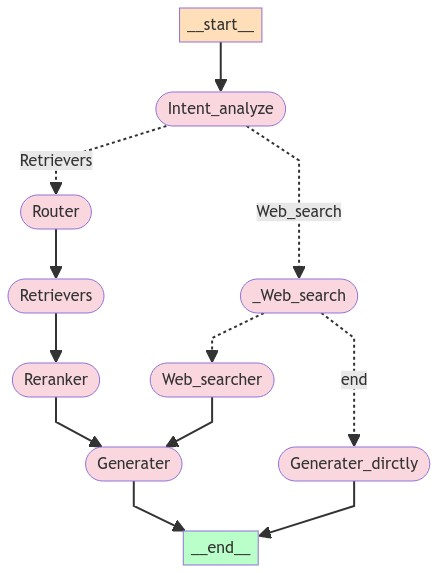

In [15]:
from IPython.display import Image, display


display(Image(app.get_graph().draw_mermaid_png()))
